In [127]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
from emtracks.interpolations import *
import matplotlib.animation as animation
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')
import os

testdir = "/home/darren/Desktop/plots/"
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/"
mapdir = datadir+"Bmaps/"
date = "/6-20/"
newdir = datadir+'test3/'

In [128]:
files = sorted(os.listdir(newdir))
e_solvernom = trajectory_solver.from_pickle(newdir+files[0])
f = interp_cole(e_solvernom.dataframe, 13)
e = 10

In [133]:
def readpkl(zstart, zend, numpoints):
    files = sorted(os.listdir(newdir))
    zsteps = np.linspace(zstart, zend, numpoints)
    data = []

    for file in files:
        x = file.split('_')
        field = float(x[0])
        name = x[4][:3]
        e_solvernom = trajectory_solver.from_pickle(newdir+file)
        phi = e_solvernom.init_conds.phi0
        theta = e_solvernom.init_conds.theta0
        for z in zsteps:
            info = interp_cole(e_solvernom.dataframe, z)
            x = info[1]
            y = info[2]
            r = tuple([(x**2 + y**2)**(1/2)])

            tuple1 = (z, field, theta, phi, name)
            data.append(tuple1 + info+r)
            
    return data 

In [134]:
x = readpkl(6, 13, 8)

In [170]:
df = pd.DataFrame(x, columns = ['z', 'field', 'theta', 'phi', 'name', 't', 'x', 'y', 'r'])


In [171]:
df

,z,field,theta,phi,name,t,x,y,r
0,6.0,3.0,0.000000,0.000000,dis,3.702318e-11,0.054105,0.038718,0.066532
1,7.0,3.0,0.000000,0.000000,dis,3.372849e-09,0.061807,0.040004,0.073623
2,8.0,3.0,0.000000,0.000000,dis,6.708602e-09,0.062539,0.043483,0.076170
3,9.0,3.0,0.000000,0.000000,dis,1.004435e-08,0.066451,0.045352,0.080452
4,10.0,3.0,0.000000,0.000000,dis,1.338012e-08,0.060766,0.045137,0.075696
...,...,...,...,...,...,...,...,...,...
85739,9.0,50.0,0.448799,1.025826,nom,1.088797e-08,-0.116600,0.006813,0.116799
85740,10.0,50.0,0.448799,1.025826,nom,1.446271e-08,0.026153,0.205738,0.207394
85741,11.0,50.0,0.448799,1.025826,nom,1.803742e-08,-0.128223,0.012799,0.128860
85742,12.0,50.0,0.448799,1.025826,nom,2.160715e-08,0.037275,0.194612,0.198149


In [277]:
def restructure(df, z):
    olddf = df[(np.isclose(df['theta'], np.pi/6, 1e-1))&(df['field'] == 5.0)&(df['z']==z)]
    
    nomdata = []
    disdata = []
    uniquephi = np.unique(olddf['phi'])
    uniquez = np.unique(df['z'])

    for phi in uniquephi:
        nomdf = olddf[(olddf['phi']==phi)&(olddf['name']=='nom')]
        disdf = olddf[(olddf['phi']==phi)&(olddf['name']=='dis')]
    
        nomdata.append(nomdf.values.tolist())
        disdata.append(disdf.values.tolist())
        
    #nomdata: zval, field, theta, phi, name, t, x, y, r
    nomphis = []
    nomxs = []
    nomys = []
    nomrs = []

    disphis = []
    disxs = []
    disys = []
    disrs = []

    zval = nomdata[0][0][0]
    fieldval = nomdata[0][0][1]
    thetaval = nomdata[0][0][2]
    
    for i in range(0, len(nomdata), 1):
        nomphis.append(nomdata[i][0][3])
        nomxs.append(nomdata[i][0][6])
        nomys.append(nomdata[i][0][7])
        nomrs.append(nomdata[i][0][8])
    
        disphis.append(disdata[i][0][3])
        disxs.append(disdata[i][0][6])
        disys.append(disdata[i][0][7])
        disrs.append(disdata[i][0][8])
        
    return (uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, disxs, disys, disrs)

In [278]:
uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, \
disxs, disys, disrs = restructure(df, 13)

Text(0, 0.5, 'Y (meters)')

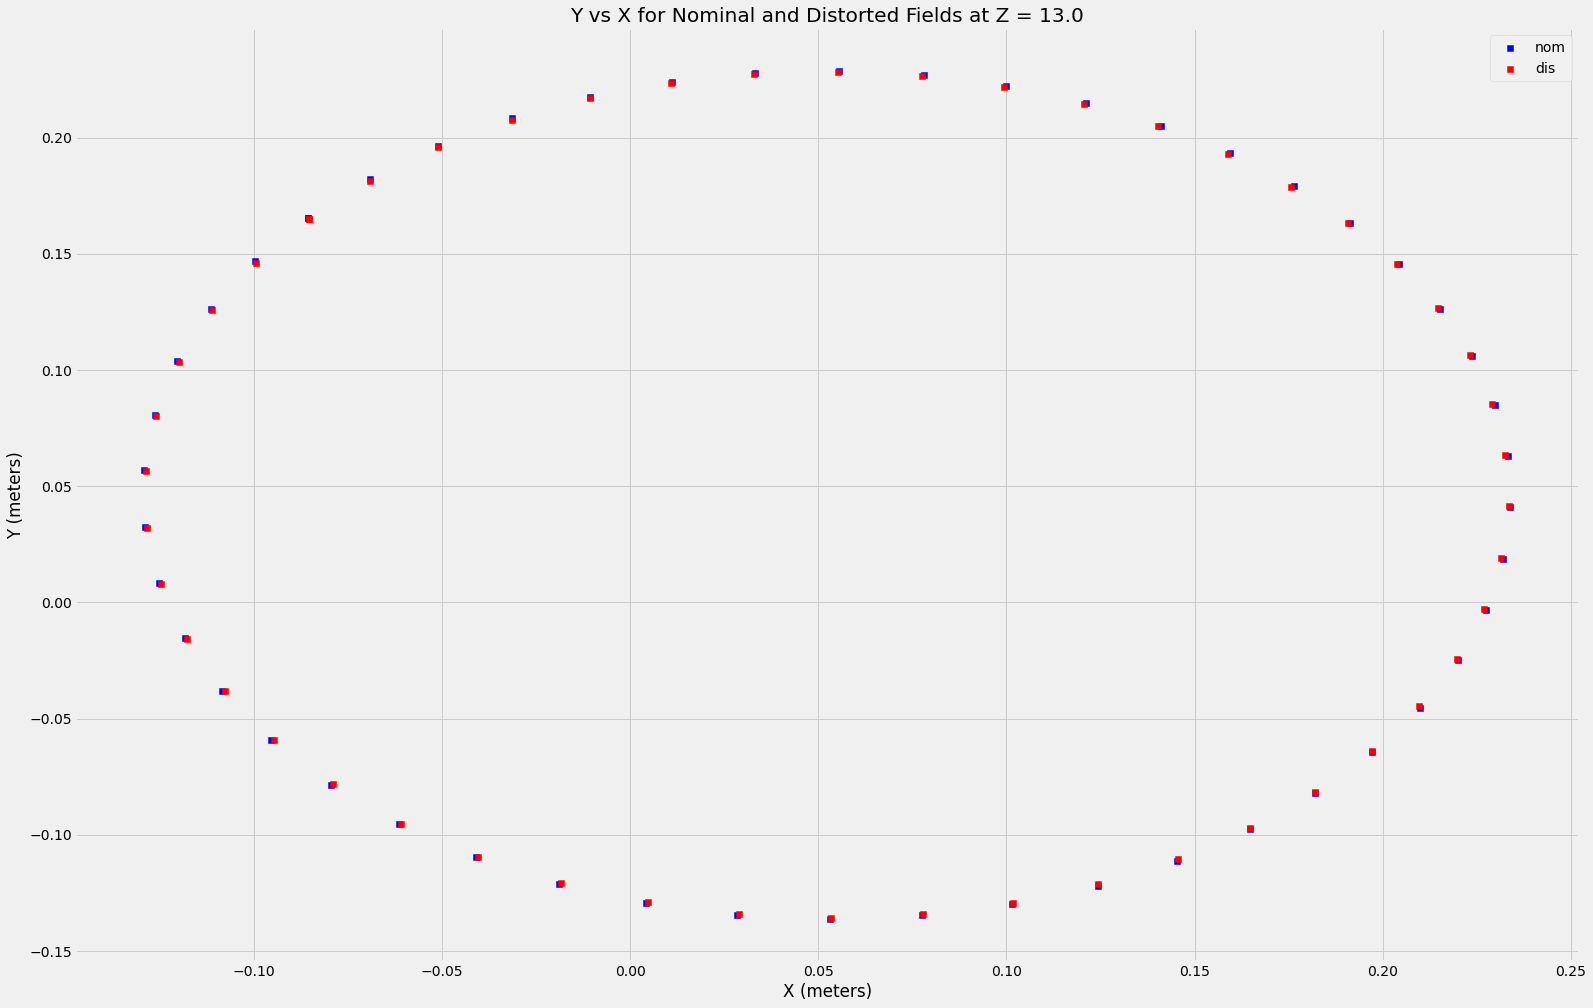

In [268]:
fig1 = plt.figure()
plt.scatter(nomxs, nomys, c='b', marker='s', label='nom')
plt.scatter(disxs, disys, c='r', marker='s', label='dis')
plt.title(f'Y vs X for Nominal and Distorted Fields at Z = {zval}')
plt.legend(loc='upper right')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

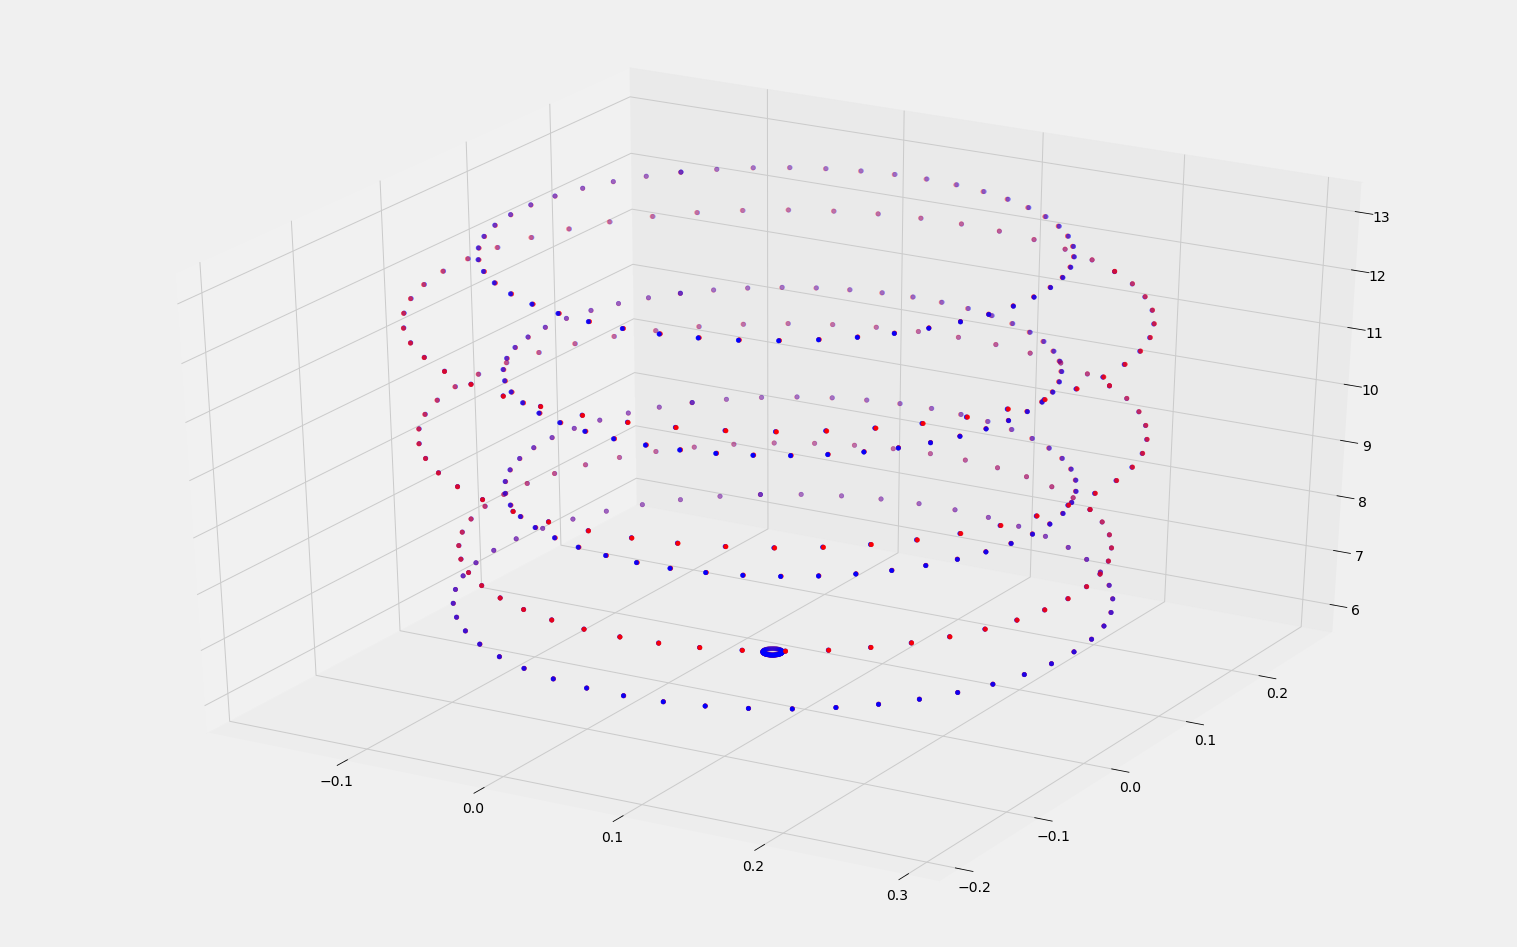

In [288]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
for i in uniquez:
    
    uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, \
    disxs, disys, disrs = restructure(df, i)
    
    ax.scatter(nomxs, nomys, i, c='b')
    ax.scatter(disxs, disys, i, c='r')
    
fig.savefig(datadir+'plot.png')